# Map fungal pathogens
Install packages in new env `conda activate geo_env`

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx # this is not in a qiime2 env 
import pandas as pd
import seaborn as sns
import re 
#import biom
import numpy as np

%matplotlib inline

In [3]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/leaves'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/leaves


# Get rarefied and labled ASV table 
> note run with a qiime2 environment 

In [3]:
#!qiime tools export \
#    --input-path /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/leaves/leaf_cm8000/rarefied_table.qza \
#    --output-path /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/leaves/leaf_cm8000/rarefied_table

Exported /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/leaves/leaf_cm8000/rarefied_table.qza as BIOMV210DirFmt to directory /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/leaves/leaf_cm8000/rarefied_table


In [7]:
# Load the BIOM table
biom_table = biom.load_table("leaf_cm8000/rarefied_table/feature-table.biom")
df_ITS = biom_table.to_dataframe()

# rename the samples 
ITS_md = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_md.tsv', sep='\t')
column_mapping = ITS_md.set_index("id")["SAMPLE_NAME"].to_dict()
# Rename df_16S columns using the mapping
df_ITS.rename(columns=column_mapping, inplace=True)

# load the taxonomy to rename the features
# this was exported in 00_Prep_MicrobiomeDataForMetabolomics notebook 
ITS_taxonomy = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/taxonomy/taxonomy.tsv', sep='\t')
ITS_taxonomy.set_index('Feature ID', inplace=True)
# Rename the index of df_ITS based on the 'Taxon' column of ITS_taxonomy
df_ITS.index = df_ITS.index.map(ITS_taxonomy['Taxon'])
# transpose and reset index
df_ITS = df_ITS.T

df_ITS.to_csv('leaves_ASVs_rarefied_labled.tsv', sep='\t')

df_ITS.head()

,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Pleosporales;f__Didymellaceae;g__Neoascochyta;s__Neoascochyta_exitialis;sh__SH1213549.10FU,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Cladosporiales;f__Cladosporiaceae;g__Cladosporium;s__Cladosporium_cladosporioides;sh__SH1334679.10FU,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Dothideales;f__Saccotheciaceae;g__Aureobasidium;s__Aureobasidium_pullulans;sh__SH1290132.10FU,k__Fungi;p__Ascomycota;c__Taphrinomycetes;o__Taphrinales;f__Taphrinaceae;g__Taphrina;s__Taphrina_sp;sh__SH1164873.10FU,k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Sordariales;f__Chaetomiaceae;g__Humicola;s__Humicola_nigrescens;sh__SH1355355.10FU,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Pleosporales;f__Pleosporaceae;g__Alternaria;s__Alternaria_subcucurbitae;sh__SH1206908.10FU,k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Chaetothyriales;f__Herpotrichiellaceae;g__Capronia;s__Capronia_sp,k__Fungi;p__Ascomycota;c__Lecanoromycetes;o__Teloschistales;f__Teloschistaceae;g__Teloschistaceae_gen_Incertae_sedis;s__Teloschistaceae_sp;sh__SH1237906.10FU,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Pleosporales;f__Leptosphaeriaceae;g__Alternariaster;s__Alternariaster_helianthi;sh__SH1389965.10FU,k__Fungi;p__Basidiomycota;c__Tremellomycetes;o__Filobasidiales;f__Filobasidiaceae;g__Filobasidium;s__Filobasidium_chernovii;sh__SH1207620.10FU,...,k__Fungi;p__Ascomycota;c__Leotiomycetes;o__Helotiales;f__Helotiales_fam_Incertae_sedis;g__Tetracladium,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Cladosporiales;f__Cladosporiaceae;g__Cladosporium;s__Cladosporium_herbarum;sh__SH1335104.10FU,k__Fungi;p__Ascomycota;c__Leotiomycetes;o__Helotiales;f__Sclerotiniaceae;g__Botrytis;s__Botrytis_caroliniana;sh__SH1336761.10FU,k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Xylariales;f__Xylariaceae;g__Xylaria,k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Xylariales;f__Microdochiaceae;g__Microdochium;s__Microdochium_nivale;sh__SH1360744.10FU,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Pleosporales;f__Pleosporaceae;g__Alternaria,k__Fungi;p__Fungi_phy_Incertae_sedis;c__Fungi_cls_Incertae_sedis;o__Fungi_ord_Incertae_sedis;f__Fungi_fam_Incertae_sedis;g__Fungi_gen_Incertae_sedis;s__Fungi_sp,k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Xylariales;f__Hypoxylaceae;g__Hypoxylon;s__Hypoxylon_fragiforme;sh__SH1400157.10FU,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Pleosporales;f__Pleosporaceae;g__Alternaria,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Pleosporales;f__Pleosporaceae;g__Alternaria
Lavaux_2021-08-31_leaf_Plot9_washed,0,0,0,43.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lavaux_2021-08-31_leaf_Plot19_washed,0,0,0,0,0,0,0,0,0,0,...,0,0,25.0,0,0,0,0,0,0,0
Lavaux_2021-08-31_leaf_Plot12_washed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lavaux_2023-08-24_leaf_Plot13_washed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lavaux_2022-08-10_leaf_Plot17_washed,0,0,104.0,0,0,0,0,0,0,0,...,0,0,0,0,0,46.0,0,0,0,0


# Get Pathogens

In [44]:
df_asv = pd.read_csv('leaves_ASVs_rarefied_labled.tsv', sep='\t', index_col=0)
df_asv.shape

(28, 649)

In [45]:
genus_list = ['Diaporthe']

pattern = "|".join(genus_list)
columns_to_keep = [col for col in df_asv.columns if re.search(pattern, col)]
pathogen_df = df_asv[columns_to_keep]
pathogen_df.shape

(28, 0)

In [46]:
collapsed_df = pathogen_df.sum(axis=1).reset_index(name='feature')
collapsed_df = collapsed_df.rename(columns={'index': 'SAMPLE_NAME'})
collapsed_df.shape

(28, 2)

In [53]:
df_md_lavaux = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv', sep='\t')
df_md_lavaux = df_md_lavaux[['SAMPLE_NAME','Latitude', 'Longitude', 'Year']]

In [54]:
df_map = collapsed_df.merge(df_md_lavaux, on='SAMPLE_NAME')
df_map.head()

,SAMPLE_NAME,feature,Latitude,Longitude,Year
0,Lavaux_2021-08-31_leaf_Plot9_washed,0.0,46.499468,6.712242,2021
1,Lavaux_2021-08-31_leaf_Plot19_washed,0.0,46.495927,6.716022,2021
2,Lavaux_2021-08-31_leaf_Plot12_washed,0.0,46.502628,6.704952,2021
3,Lavaux_2023-08-24_leaf_Plot13_washed,0.0,46.499992,6.706109,2023
4,Lavaux_2022-08-10_leaf_Plot17_washed,0.0,46.488222,6.721331,2022


In [55]:
# add log2? 
df_map['log2_feature'] = np.log2(df_map['feature'] + 1e-6)
df_map.tail()

,SAMPLE_NAME,feature,Latitude,Longitude,Year,log2_feature
23,Lavaux_2023-08-24_leaf_Plot4_washed,0.0,46.498857,6.708072,2023,-19.931569
24,Lavaux_2022-08-10_leaf_Plot15_washed,0.0,46.506067,6.702391,2022,-19.931569
25,Lavaux_2022-08-10_leaf_Plot5_washed,0.0,46.496407,6.708712,2022,-19.931569
26,Lavaux_2021-08-31_leaf_Plot17_washed,0.0,46.488222,6.721331,2021,-19.931569
27,Lavaux_2021-08-31_leaf_Plot4_washed,0.0,46.498857,6.708072,2021,-19.931569


In [50]:
# Convert to GeoDataFrame
gdf_samples = gpd.GeoDataFrame(df_map, geometry=gpd.points_from_xy(df_map.Longitude, df_map.Latitude), crs="EPSG:4326")

# Convert to Web Mercator (needed for contextily basemap)
gdf_samples = gdf_samples.to_crs(epsg=3857)


# Map

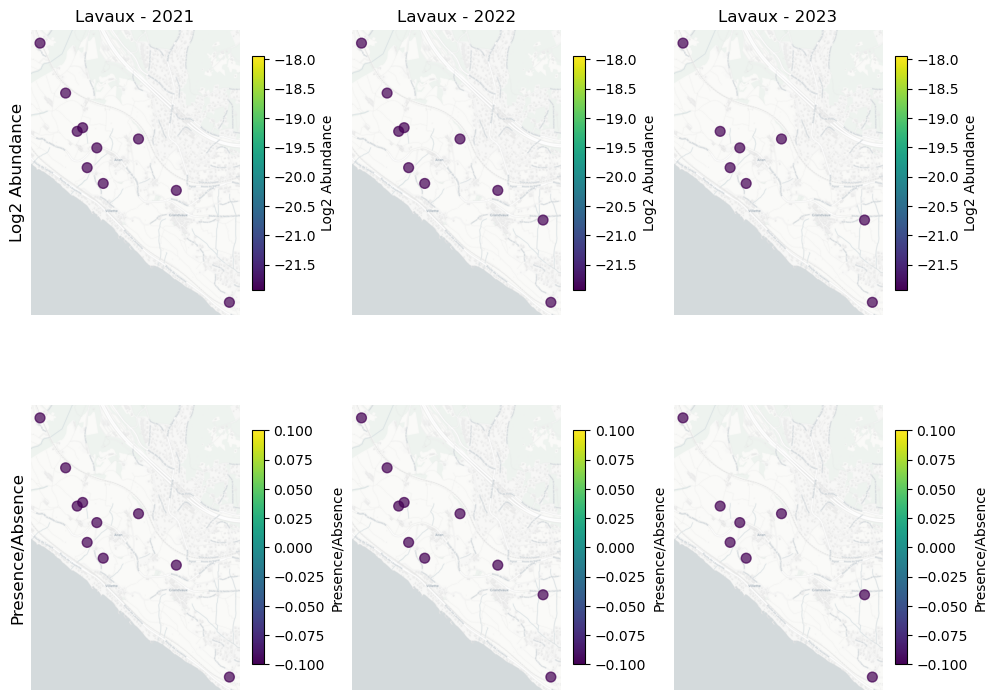

In [52]:
# Filter for samples that start with "Lavaux_"
df_lavaux = df_map[df_map['SAMPLE_NAME'].str.startswith('Lavaux_')].copy()

# Avoid log(0) by adding a small constant
df_lavaux['log2_feature'] = np.log2(df_lavaux['feature'] + 1e-6)

# Binary transformation (Presence = 1, Absence = 0)
df_lavaux['binary_feature'] = (df_lavaux['feature'] > 0).astype(int)

# Convert to GeoDataFrame
gdf_lavaux = gpd.GeoDataFrame(df_lavaux, geometry=gpd.points_from_xy(df_lavaux.Longitude, df_lavaux.Latitude), crs="EPSG:4326")
gdf_lavaux = gdf_lavaux.to_crs(epsg=3857)  # Convert to Web Mercator

# Define years and transformations
years = [2021, 2022, 2023]
transformations = ['log2_feature', 'binary_feature']
titles = ['Log2 Abundance',  'Presence/Absence']

# Create 3 rows (transformations) x 3 columns (years)
fig, axes = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)

for row, transform in enumerate(transformations):
    for col, year in enumerate(years):
        ax = axes[row, col]
        
        # Subset for the given year
        gdf_year = gdf_lavaux[gdf_lavaux['Year'] == year]
        
        # Plot
        gdf_year.plot(ax=ax, column=transform, cmap='viridis', markersize=50, legend=False, alpha=0.7)
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution=False)

        # Add colorbar with smaller size
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf_lavaux[transform].min(), vmax=gdf_lavaux[transform].max()))
        sm._A = []  # Empty array for colorbar
        cbar = fig.colorbar(sm, ax=ax, shrink=0.6)  # Adjust shrink factor here
        cbar.set_label(titles[row], fontsize=10)

        # Formatting
        if col == 0:
            ax.set_ylabel(titles[row], fontsize=12)
        if row == 0:
            ax.set_title(f"Lavaux - {year}", fontsize=12)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_frame_on(False)

plt.tight_layout()
plt.show()
